# Coursework 1 - Supervised learning

**Replace CID in the file name with your CID**

# Outline


- [Task 1](#task-1): Regression <a name="index-task-1"></a>
  - [(1.1)](#task-11) Random Forest <a name="index-task-11"></a>
    - [(1.1.1)](#task-111) <a name="index-task-111"></a>
    - [(1.1.2)](#task-112) <a name="index-task-112"></a>
    - [(1.1.3)](#task-113) <a name="index-task-113"></a>
  - [(1.2)](#task-12) Multi-layer Perceptron <a name="index-task-12"></a>
    - [(1.2.1)](#task-121) <a name="index-task-121"></a>
    - [(1.2.2)](#task-122) <a name="index-task-122"></a>
    - [(1.2.3)](#task-123) <a name="index-task-123"></a>
- [Task 2](#task-2): Classification <a name="index-task-2"></a>
  - [(2.1)](#task-21) k-Nearest Neighbours <a name="index-task-21"></a>
    - [(2.1.1)](#task-211)  <a name="index-task-211"></a>
    - [(2.1.2)](#task-212) <a name="index-task-212"></a>
    - [(2.1.3)](#task-213) <a name="index-task-213"></a>
  - [(2.2)](#task-22) Logistic regression vs kernel logistic regression <a name="index-task-22"></a>
    - [(2.2.1)](#task-221) <a name="index-task-221"></a>
    - [(2.2.2)](#task-222) <a name="index-task-222"></a>
    - [(2.2.3)](#task-223) <a name="index-task-223"></a>



---



In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import make_classification, fetch_california_housing
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

<a name="task-1"></a>

# (1) Task 1: Regression [(index)](#index-task-1)

<a name="task-11"></a>

## (1.1) Random Forest [(index)](#index-task-11)

<a name="task-111"></a>

### (1.1.1) [(index)](#index-task-111)

<a name="task-112"></a>

### (1.1.2) [(index)](#index-task-112)

<a name="task-113"></a>

### (1.1.3) [(index)](#index-task-113)



---



<a name="task-12"></a>

## (1.2) Multi-layer Perceptron [(index)](#index-task-12)

<a name="task-121"></a>

### (1.2.1) [(index)](#index-task-121)

<a name="task-122"></a>

### (1.2.2) [(index)](#index-task-122)

<a name="task-123"></a>

### (1.2.3) [(index)](#index-task-123)



---



<a name="task-2"></a>

# (2) Task 2: Classification [(index)](#index-task-2)

<a name="task-21"></a>

## (2.1) k-Nearest Neighbours [(index)](#index-task-21)

<a name="task-211"></a>

### (2.1.1) [(index)](#index-task-211)

We standardise the dataset using the convention discussed in the lecture. This makes it easier to compare the performance of different models.

In [2]:
def standardise(X, X_train_=None):
    """
    Standardise features.
    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.
    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0, keepdims=True)
    sigma = np.std(X_train_, axis=0, keepdims=True)
    X_std = (X - mu) / sigma
    return X_std

In [3]:
# training set data
cancer_samples = pd.read_csv('brain_cancer_samples.csv')
X_train_df = cancer_samples[cancer_samples.columns[np.arange(12)!=11]]
y_train_df = cancer_samples[cancer_samples.columns[-1]]

# transform training data into standardised arrays
X_train = standardise(np.array(X_train_df))[:,1:] # drop the Patient ID column
y_train = np.array(y_train_df)

# test set data, dropping the Patient ID column
cancer_test = pd.read_csv('brain_cancer_test.csv')
X_test_df = cancer_test[cancer_test.columns[np.arange(12)!=11]]
y_test_df = cancer_test[cancer_test.columns[-1]]

# transform test data into standardised arrays
X_test = standardise(np.array(X_test_df),np.array(X_train_df))[:,1:] # drop the Patient ID column
y_test = np.array(y_test_df)

# observe features
print(f'number of predictors = {X_test_df.shape[1]}')
X_test_df.head()

number of predictors = 11


,Patient ID,2D Surface,Contour Size,Total Surface,Density,Diameter,Primary Axis,Shape Variation,Location,Eccentricity_Real,Eccentricity_Imag
0,1,16.0,15.656854,16.5,0.969697,4.513517,4.654326,5.575232,1,4.040000e-17,0.659446
1,2,23651.5,1450.520980,38721.0,0.610818,173.533931,169.741043,236.322433,0,5.930000e-17,0.968694
2,3,10.5,18.727922,12.0,0.875000,3.656366,2.158408,8.873440,4,2.440000e-16,3.987627
3,4,3514.5,1242.673224,54204.5,0.064838,66.893949,291.385498,321.823425,3,2.870000e-17,0.468861
4,5,2127.5,300.492421,2910.0,0.731100,52.046298,47.092342,70.562317,3,6.830000e-17,1.115862


In [4]:
def euclidian_distance(p, q):
    """Compute the Euclidean distance between two sets of points."""
    return np.sqrt(np.sum((p-q)**2, axis=1))

In [5]:
def k_neighbours(X_train, X_test, k=5, return_distance=False):
    """Find the k nearest neighbours of each point in X_test from the points in X_train."""
    n_neighbours = k
    dist = []
    neigh_ind = []

    # compute distance from each point x_test in X_test to all points in X_train
    point_dist = [euclidian_distance(x_test, X_train) for x_test in X_test]

    # determine which k training points are closest to each test point
    for row in point_dist:
        enum_neigh = enumerate(row)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]
        ind_list = [tup[0] for tup in sorted_neigh]
        dist_list = [tup[1] for tup in sorted_neigh]
        dist.append(dist_list)
        neigh_ind.append(ind_list)

    # return distances together with indices of k nearest neighbours
    if return_distance:
        return np.array(dist), np.array(neigh_ind)

    return np.array(neigh_ind)

In [6]:
def predict(X_train, y_train, X_test, k=5):
    """
    Predict the labels for the test dataset using the k-nearest neighbours algorithm.
    """
    # find k nearest neighbours for each test point
    neighbours = k_neighbours(X_train, X_test, k=k)

    # predict labels based on majority vote of k nearest neighbours
    y_pred = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours])

    return y_pred

In [7]:
def score(X_train, y_train, X_test, y_test, k):
    """
    Compute the accuracy (micro-accuracy) score of a k-nearest neighbours classifier.
    """
    # predict labels for test set using k-nearest neighbours algorithm
    y_pred = predict(X_train, y_train, X_test, k=k)
    
    # compute accuracy 
    accuracy = float(sum(y_pred == y_test)) / float(len(y_test))
    
    return accuracy

In [8]:
# create a list of five index arrays, corresponding to each of the five folds.
folds_indexes = np.split(np.arange(len(y_train)), 5)

In [9]:
def cross_validation_score(X_train, y_train, folds, k):
    """
    Perform k-fold cross-validation to evaluate the performance of a k-nearest neighbours classifier.
    """
    # initialise scores
    scores = []
    
    # iterate over each fold
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
        
        # separate training and validation data
        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]
        X_val_i = X_train[val_indexes, :]
        y_val_i = y_train[val_indexes]
        
        # train k-nearest neighbours classifier and evaluate its performance
        score_i = score(X_train_i, y_train_i, X_val_i, y_val_i, k=k)
        scores.append(score_i)

    # return average score
    return sum(scores) / len(scores)

In [10]:
def choose_best_k(X_train, y_train, folds, k_range):
    """
    Choose the best value of k for a k-nearest neighbours classifier using cross-validation.
    """
    # initialise scores
    k_scores = np.zeros((len(k_range),))
    
    # iterate over each k
    for i, k in enumerate(k_range):
        k_scores[i] = cross_validation_score(X_train, y_train, folds, k)
        print(f'CV_ACC@k={k}: {k_scores[i]:.3f}')

    # select k with highest cross-validation score
    best_k_index = np.argmax(k_scores)
    return k_range[best_k_index]

In [11]:
best_k = choose_best_k(X_train, y_train, folds_indexes, np.arange(1, 21))
print('Optimal value of k:', best_k)

CV_ACC@k=1: 0.648
CV_ACC@k=2: 0.662
CV_ACC@k=3: 0.745
CV_ACC@k=4: 0.676
CV_ACC@k=5: 0.738
CV_ACC@k=6: 0.703
CV_ACC@k=7: 0.690
CV_ACC@k=8: 0.724
CV_ACC@k=9: 0.690
CV_ACC@k=10: 0.676
CV_ACC@k=11: 0.683
CV_ACC@k=12: 0.648
CV_ACC@k=13: 0.662
CV_ACC@k=14: 0.655
CV_ACC@k=15: 0.683
CV_ACC@k=16: 0.662
CV_ACC@k=17: 0.648
CV_ACC@k=18: 0.655
CV_ACC@k=19: 0.641
CV_ACC@k=20: 0.628
Optimal value of k: 3


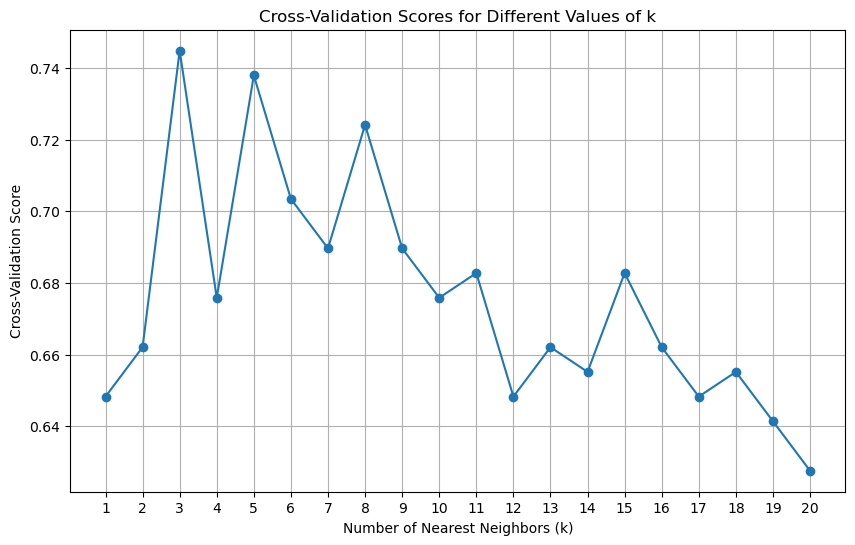

In [12]:
# define range of k values
k_values = np.arange(1, 21)

# compute cross-validation scores for each k
cross_val_scores = [cross_validation_score(X_train, y_train, folds_indexes, k) for k in k_values]

# plot graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, cross_val_scores, marker='o', linestyle='-')
plt.title('Cross-Validation Scores for Different Values of k')
plt.xlabel('Number of Nearest Neighbors (k)')
plt.ylabel('Cross-Validation Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [13]:
# assess performance of optimal k on test set
print(f"Micro-averaged accuracy of kNN model on the test set: {score(X_train, y_train, X_test, y_test, best_k)}")

Micro-averaged accuracy of kNN model on the test set: 0.6666666666666666


In [14]:
# identify minority class
np.bincount(y_train), np.bincount(y_test)

(array([47, 80, 18]), array([18, 35,  7]))

The minority class is class 2 since there are only 18 values in that class for the training set and 7 values in that class for the test set, which is the least.

In [15]:
def confusion_matrix(y_true, y_pred, num_class):
    """
    Compute the confusion matrix for the classification task.
    Parameters:
        y_true (np.ndarray): The true labels with shape (N,).
        y_pred (np.ndarray): The predicted labels with shape (N,).
        num_class (int): The number of classes in the classification task.
    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: A tuple containing four arrays:
            - true_positives (TP) for each class.
            - true_negatives (TN) for each class.
            - false_positives (FP) for each class.
            - false_negatives (FN) for each class.
    """
    # initialise variables to store counts for each class
    true_positives = np.zeros(num_class, dtype=int)
    true_negatives = np.zeros(num_class, dtype=int)
    false_positives = np.zeros(num_class, dtype=int)
    false_negatives = np.zeros(num_class, dtype=int)
    
    # iterate over each class
    for class_ in range(num_class):
        # calculate true/false positives/negatives for the current class
        true_positives[class_] = np.sum((y_true == class_) & (y_pred == class_))
        true_negatives[class_] = np.sum((y_true != class_) & (y_pred != class_))
        false_positives[class_] = np.sum((y_true != class_) & (y_pred == class_))
        false_negatives[class_] = np.sum((y_true == class_) & (y_pred != class_))
    
    return true_positives, true_negatives, false_positives, false_negatives

In [16]:
def micro(true_positives, true_negatives, false_positives, false_negatives):
    """Compute micro-averaged accuracy and precision."""
    # calculate accuracy
    micro_accuracy = np.sum(true_positives) / (np.sum(true_positives) + 0.5 * (np.sum(false_positives) + np.sum(false_negatives)))
    
    # calculate precision
    micro_precision = np.sum(true_positives) / (np.sum(true_positives) + np.sum(false_positives))
    return micro_accuracy, micro_precision

In [17]:
def macro(true_positives, true_negatives, false_positives, false_negatives):
    """Compute macro-averaged accuracy and precision."""
    # calculate accuracy for each class
    class_accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

    # calculate precision for each class
    class_precision = true_positives / (true_positives + false_negatives)

    # calculate macro-averaged accuracy
    macro_accuracy = np.mean(class_accuracy)

    # calculate macro-averaged precision
    macro_precision = np.mean(class_precision)

    return macro_accuracy, macro_precision

In [18]:
def class_weighted(true_positives, true_negatives, false_positives, false_negatives, weights):
    """Compute class-weighted accuracy and precision."""
    # calculate accuracy and precision for each class
    class_accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    class_precision = true_positives / (true_positives + false_negatives)

    # initialise class-weighted accuracy and precision
    class_weighted_accuracy, class_weighted_precision = 0, 0
    
    # calculate class-weighted accuracy and precision
    for i in range(len(weights)):
        class_weighted_accuracy += weights[i] * class_accuracy[i]
        class_weighted_precision += weights[i] * class_precision[i]
    
    return class_weighted_accuracy, class_weighted_precision

In [19]:
# predict labels for test set using k-nearest neighbours algorithm
y_pred_knn = predict(X_train, y_train, X_test, k=3)

# number of classes
num_class = 3

# compute confusion matrix
true_positives, true_negatives, false_positives, false_negatives = confusion_matrix(y_test, y_pred_knn, num_class)

# print confusion matrix values for each class
for class_ in range(num_class):
    print(f"Class {class_}:")
    print("True Positives:", true_positives[class_])
    print("True Negatives:", true_negatives[class_])
    print("False Positives:", false_positives[class_])
    print("False Negatives:", false_negatives[class_])
    print()

# micro-averaged accuracy and precision
micro_accuracy, micro_precision = micro(true_positives, true_negatives, false_positives, false_negatives)

# macro-averaged accuracy and precision
macro_accuracy, macro_precision = macro(true_positives, true_negatives, false_positives, false_negatives)

# class-weighted accuracy and precision
class_weighted_accuracy, class_weighted_precision = class_weighted(true_positives, true_negatives, false_positives, false_negatives, np.bincount(y_test)/len(y_test))

print(f"Micro-averaged accuracy: {micro_accuracy}")
print(f"Micro-averaged precision: {micro_precision}")
print("")

print(f"Macro-averaged accuracy: {macro_accuracy}")
print(f"Macro-averaged precision: {macro_precision}")
print("")

print(f"Class-weighted accuracy:{class_weighted_accuracy}")
print(f"Class-weighted precision:{class_weighted_precision}")
print("")

Class 0:
True Positives: 8
True Negatives: 35
False Positives: 7
False Negatives: 10

Class 1:
True Positives: 28
True Negatives: 12
False Positives: 13
False Negatives: 7

Class 2:
True Positives: 4
True Negatives: 53
False Positives: 0
False Negatives: 3

Micro-averaged accuracy: 0.6666666666666666
Micro-averaged precision: 0.6666666666666666

Macro-averaged accuracy: 0.7777777777777777
Macro-averaged precision: 0.6052910052910053

Class-weighted accuracy:0.7147222222222223
Class-weighted precision:0.6666666666666667



In [20]:
# accuracy of each class
class_accuracy = (true_positives + true_negatives) / (true_negatives + true_negatives + false_positives + false_negatives)

# accuracy of minority class (class 2)
minority_class_accuracy = class_accuracy[2]

# precision of each class
class_precision = true_positives / (true_positives + false_positives)

# precision of minority class (class 2)
minority_class_precision = class_precision[2]

print(f"Minority class accuracy: {minority_class_accuracy}")
print(f"Minority class precision: {minority_class_precision}")

Minority class accuracy: 0.5229357798165137
Minority class precision: 1.0


We can see that the micro-averaged accuracy is lower than the class-weighted accuracy and the macro-averaged accuracy is higher than the class-weighted accuracy. We can deduce from this that one class has much lower accuracy. 

Calculating the accuracy of the minority class, we find that it has an accuracy of 0.52 which is very low compared to the class-weighted accuracy, implying that the kNN classifier poorly predicts the minority class in comparison to the other two classes (there are many false positives and false negatives).

Calculating the precision of the minority class, we find that it has a precision of 1.0. This tells us that when the classifier predicts an instance as belonging to the minority class, it is always correct (there are no false positives).

Overall, the kNN classifier doesn't do too bad on the test set, with values above 0.6 for all six metrics. The minority class has a much higher precision than the other two classes but a much lower accuracy, meaning the kNN classifier doesn't do too well at predicting the minority class.

<a name="task-212"></a>

### (2.1.2) [(index)](#index-task-212)

This weighting strategy gives more weight to smaller classes, multiplying by a factor inversely proportional to the frequency of the class. Closer neighbours are also given more weight. The aim of this strategy is to improve the prediction of the minority class by giving it more weight.

In [21]:
def weighted_predict(X_train, y_train, X_test, k=3):
    """
    Predict class labels for test data using a weighted k-nearest neighbors (kNN) algorithm.
    """
    # find k nearest neighbours for each test point
    distances, neighbours = k_neighbours(X_train, X_test, k=k, return_distance=True)
    
    # initialise array to store weighted votes for each class
    weighted_votes = np.zeros((X_test.shape[0], np.max(y_train) + 1))
    
    # iterate over each test point
    for i, neighbour_indices in enumerate(neighbours):
        # get corresponding labels of k nearest neighbors
        neighbour_labels = y_train[neighbour_indices]
    
        # calculate weights for each neighbour based on their distance and class frequency
        weights = np.zeros_like(neighbour_labels, dtype=float)
        for j, label in enumerate(neighbour_labels):
            # calculate the frequency of the specific class label within the neighbourhood
            class_frequency = np.sum(neighbour_labels[:j+1] == label) 
            # assign weights inversely proportional to class frequency
            weights[j] = 1 / (distances[i, j] + 1e-6) * (1 / (class_frequency + 1e-6))
        
        # accumulate weighted votes for each class
        for j, label in enumerate(neighbour_labels):
            weighted_votes[i, label] += weights[j]
    
    # predict class with maximum weighted vote for each test point
    y_pred = np.argmax(weighted_votes, axis=1)
    
    return y_pred

In [22]:
def weighted_score(X_train, y_train, X_test, y_test, k=3):
    """
    Compute the accuracy score of predictions made by the weighted k-nearest neighbors (kNN) algorithm.
    """
    y_pred = weighted_predict(X_train, y_train, X_test, k=k)
    return float(sum(y_pred == y_test)) / float(len(y_test))


In [23]:
def weighted_cross_validation_score(X_train, y_train, folds, k):
    """
    Compute the cross-validation score using the weighted k-nearest neighbors (kNN) algorithm.
    """
    scores = []
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]
        X_val_i = X_train[val_indexes, :] 
        y_val_i = y_train[val_indexes] 

        # compute score using weighted kNN
        score_i = weighted_score(X_train_i, y_train_i, X_val_i, y_val_i, k=k) 
        scores.append(score_i)

    # Return the average score
    return sum(scores) / len(scores)

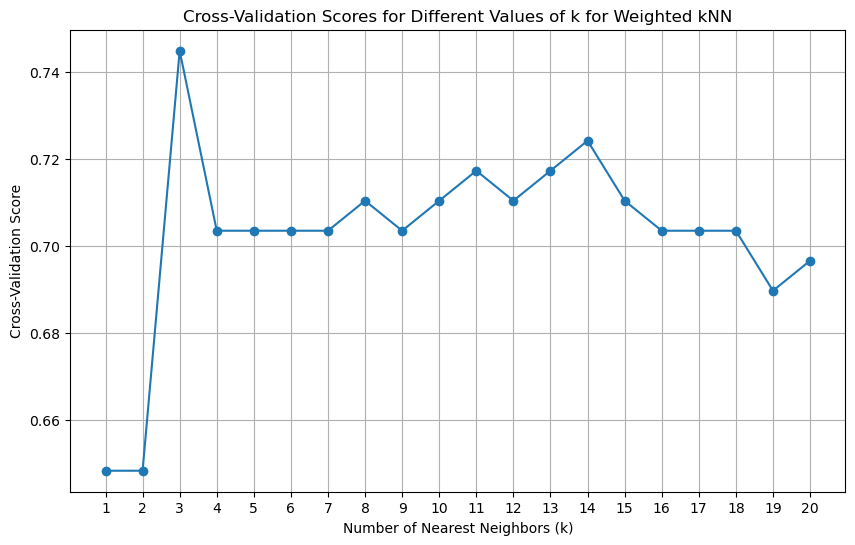

In [24]:
# define range of k values
k_values = np.arange(1, 21)

# compute cross-validation scores for each k
cross_val_scores = [weighted_cross_validation_score(X_train, y_train, folds_indexes, k) for k in k_values]

# plot graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, cross_val_scores, marker='o', linestyle='-')
plt.title('Cross-Validation Scores for Different Values of k for Weighted kNN')
plt.xlabel('Number of Nearest Neighbors (k)')
plt.ylabel('Cross-Validation Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [25]:
# predict labels for test set using k-nearest neighbours algorithm
y_weighted_pred = weighted_predict(X_train, y_train, X_test, k=3)

# number of classes
num_class = 3

# compute confusion matrix
true_positives, true_negatives, false_positives, false_negatives = confusion_matrix(y_test, y_weighted_pred, num_class)

# print confusion matrix values for each class
for class_ in range(num_class):
    print(f"Class {class_}:")
    print("True Positives:", true_positives[class_])
    print("True Negatives:", true_negatives[class_])
    print("False Positives:", false_positives[class_])
    print("False Negatives:", false_negatives[class_])
    print()

# micro-averaged accuracy and precision
micro_accuracy, micro_precision = micro(true_positives, true_negatives, false_positives, false_negatives)

# macro-averaged accuracy and precision
macro_accuracy, macro_precision = macro(true_positives, true_negatives, false_positives, false_negatives)

# class-weighted accuracy and precision
class_weighted_accuracy, class_weighted_precision = class_weighted(true_positives, true_negatives, false_positives, false_negatives, np.bincount(y_test)/len(y_test))

print(f"Micro-averaged accuracy: {micro_accuracy}")
print(f"Micro-averaged precision: {micro_precision}")
print("")

print(f"Macro-averaged accuracy: {macro_accuracy}")
print(f"Macro-averaged precision: {macro_precision}")
print("")

print(f"Class-weighted accuracy:{class_weighted_accuracy}")
print(f"Class-weighted precision:{class_weighted_precision}")
print("")

Class 0:
True Positives: 10
True Negatives: 35
False Positives: 7
False Negatives: 8

Class 1:
True Positives: 29
True Negatives: 14
False Positives: 11
False Negatives: 6

Class 2:
True Positives: 3
True Negatives: 53
False Positives: 0
False Negatives: 4

Micro-averaged accuracy: 0.7
Micro-averaged precision: 0.7

Macro-averaged accuracy: 0.8000000000000002
Macro-averaged precision: 0.6042328042328042

Class-weighted accuracy:0.7519444444444444
Class-weighted precision:0.7000000000000001



In [26]:
# accuracy of each class
class_accuracy = (true_positives + true_negatives) / (true_negatives + true_negatives + false_positives + false_negatives)

# accuracy of minority class (class 2)
minority_class_accuracy = class_accuracy[2]

# precision of each class
class_precision = true_positives / (true_positives + false_positives)

# precision of minority class (class 2)
minority_class_precision = class_precision[2]

print(f"Minority class accuracy: {minority_class_accuracy}")
print(f"Minority class precision: {minority_class_precision}")

Minority class accuracy: 0.509090909090909
Minority class precision: 1.0


We find that all six metrics have improved compared to the values in 2.1.1, meaning the weighted kNN model is more effective at making predictions than the unweighted one. We obtain fewer false positives and false negatives using the weighted model.

Observing the minority class spefically, we find that the minority class accuracy is very similar, and the minority class precision is still 1.0. 

Therefore, the weighted kNN model is much better overall, however, it is not much more effective at predicting the minority class. A different weighting strategy may be more appropriate.

<a name="task-213"></a>

### (2.1.3) [(index)](#index-task-213)

In [27]:
# merge classes 1 and 2 into class 1 (malignant tumor diagnosis)
y_train_binary = np.where(y_train == 0, 0, 1)

def predict_binary1(X_train, y_train, X_test, k1 = best_k):
    """
    Train a kNN model where where the two classes are ‘benign tumour diagnosis’ (class 0)
    and ‘malignant tumour diagnosis’ (classes 1 and 2 combined).
    """
    # prediction for y_test_binary
    y_pred1 = predict(X_train, y_train_binary, X_test, k = k1)
    return y_pred1

def predict_binary2(X_train, y_train, X_test, k2 = 1):
    """
    Perform a 2-step binary classification for the original three-class classification problem.
    """
    y_pred1 = predict(X_train, y_train_binary, X_test, best_k)
    
    # modify training and testing data
    X_test_modified = X_test[y_pred1 == 1]
    X_train_modified = X_train[y_train_binary == 1]
    y_train_modified = y_train[y_train_binary == 1]
    
    # prediction for y_test
    y_pred2 = y_pred1.copy()
    y_pred2[y_pred1 == 1] = predict(X_train_modified, y_train_modified, X_test_modified, k = k2)
    return y_pred2

In [28]:
# predict labels for test set using k-nearest neighbours algorithm
y_pred_binary = predict_binary2(X_train, y_train, X_test, k2 = 1)

# number of classes
num_class = 3

# compute confusion matrix
true_positives, true_negatives, false_positives, false_negatives = confusion_matrix(y_test, y_pred_binary, num_class)

# print confusion matrix values for each class
for class_ in range(num_class):
    print(f"Class {class_}:")
    print("True Positives:", true_positives[class_])
    print("True Negatives:", true_negatives[class_])
    print("False Positives:", false_positives[class_])
    print("False Negatives:", false_negatives[class_])
    print()

# micro-averaged accuracy and precision
micro_accuracy, micro_precision = micro(true_positives, true_negatives, false_positives, false_negatives)

# macro-averaged accuracy and precision
macro_accuracy, macro_precision = macro(true_positives, true_negatives, false_positives, false_negatives)

# class-weighted accuracy and precision
class_weighted_accuracy, class_weighted_precision = class_weighted(true_positives, true_negatives, false_positives, false_negatives, np.bincount(y_test)/len(y_test))

print(f"Micro-averaged accuracy: {micro_accuracy}")
print(f"Micro-averaged precision: {micro_precision}")
print("")

print(f"Macro-averaged accuracy: {macro_accuracy}")
print(f"Macro-averaged precision: {macro_precision}")
print("")

print(f"Class-weighted accuracy:{class_weighted_accuracy}")
print(f"Class-weighted precision:{class_weighted_precision}")
print("")

Class 0:
True Positives: 8
True Negatives: 35
False Positives: 7
False Negatives: 10

Class 1:
True Positives: 28
True Negatives: 13
False Positives: 12
False Negatives: 7

Class 2:
True Positives: 5
True Negatives: 53
False Positives: 0
False Negatives: 2

Micro-averaged accuracy: 0.6833333333333333
Micro-averaged precision: 0.6833333333333333

Macro-averaged accuracy: 0.7888888888888889
Macro-averaged precision: 0.652910052910053

Class-weighted accuracy:0.7263888888888889
Class-weighted precision:0.6833333333333335



We find that the 2-step kNN performs very well, but not as well as the weighted version of kNN from 2.1.2. 

Weighted kNN has the best score for all six metrics. 2-step kNN has the second best for all six metrics, and unweighted kNN performs the worst for all six metrics. However, the scores for each model are relatively close.

We would expect weighted kNN to perform very well as it is able to make more informed classification decisions, especially considering the fact that the classes differ greatly in size.

2-step kNN might perform worse than weighted kNN due to the loss of information from separating the classification into two separate binary classification tasks.

Unweighted kNN may perform the worst since it treats all neighbours equally, resulting in outliers having a big effect on the accuracy of the model. It also prioritises the majority class, leading to predictions with lower accuracy and bias, especially for the minority class.



---



<a name="task-22"></a>

## (2.2) Logistic regression vs kernel logistic regression [(index)](#index-task-22)

<a name="task-221"></a>

### (2.2.1) [(index)](#index-task-221)

In [29]:
# formulation of the binary classification task
y_train_binary = np.where(y_train == 0, 0, 1)
y_test_binary = np.where(y_test == 0, 0, 1)

In [30]:
def logistic(z):
    """Compute the logistic sigmoid function."""
    return 1. / (1. + np.exp(-z))

In [31]:
def predict_log(X, beta):
    """Predict the probability of belonging to a class using logistic regression."""
    y_log = logistic(X @ beta)
    return y_log.squeeze()

In [32]:
def initialise(size):
    """ 
    Initialise beta parameter.
    Argument:
    size: Size of the parameter vector beta
    Returns:
    beta: Initialised vector of shape (size, 1)
    """
    beta = np.zeros((size, 1))
    return beta

In [33]:
def propagate(X, y, beta, lambda1=0.0025):
    """
    Compute the mean sample loss and its gradient with respect to beta.
    Arguments:
    X: Data of shape (N, p+1)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p+1
    lambda1: Regularisation parameter for the magnitude of beta
    Returns:
    mean_loss: Mean sample loss for the negative log-likelihood
    dbeta: Gradient of the mean sample loss with respect to beta
    """
    y_log = predict_log(X, beta)

    # mean sample loss function
    mean_loss = - np.mean(y * np.log(y_log) + (1-y) * np.log(1 - y_log) + lambda1/2 * np.linalg.norm(beta) ** 2)

    # derivatives
    dbeta = np.mean(X.T * (y_log - y), axis=1).reshape(-1, 1)
    dbeta += lambda1 * beta
    
    mean_loss = np.squeeze(mean_loss)
    
    # store gradients in a dictionary
    grads = {'dbeta': dbeta}
      
    return grads, mean_loss

In [34]:
def optimise(X, y, beta, num_iterations=1000, learning_rate=0.1, print_loss=False):
    """
    Optimise the logistic regression parameters using gradient descent.
    Arguments:
    X: Data of shape (N, p+1)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p+1
    num_iterations: Number of iterations
    learning_rate: Step size in updating procedure
    print_loss: 'True' to print the mean loss every 100 iterations
    Returns:
    params: Dictionary containing the parameter vector beta
    grads: Dictionary containing the gradient
    mean_loss_history: List of all the mean loss values computed during the optimisation (can be used to plot the learning curve)
    """
    mean_loss_history = []
    
    for i in range(num_iterations):

        # calculating the loss and gradients 
        grads, mean_loss = propagate(X, y, beta)
        
        # retrieving derivatives from grads
        dbeta = grads['dbeta']
        
        # updating procedure
        beta = beta - learning_rate * dbeta 
        
        # record the loss values
        if i % 100 == 0:
            mean_loss_history.append(mean_loss)
        
        # printing the loss every 100 iterations
        if print_loss and i % 100 == 0:
            print ('Mean loss after iteration %i: %f' %(i, mean_loss))
    
    # saving parameters and gradients in dictionary
    params = {'beta': beta}
    grads = {'dbeta': dbeta}
    
    return params, grads, mean_loss_history

In [35]:
def predict(X_test, beta):
    """
    Predict the binary class labels for the test set using logistic regression.
    Arguments:
    X_test: Test set of shape (N_test, p+1)
    beta: Parameter vector, a numpy array of size p+1
    Returns:
    y_pred: Vector containing all binary predictions (0/1) for X_test
    """
    N_test = X_test.shape[0]
    y_pred = np.zeros((N_test, 1))
    beta = beta.reshape(X_test.shape[1], 1)
    
    # predicting the probabilities
    y_log = predict_log(X_test, beta)
    
    y_pred = y_log.round().reshape(1, -1)
    
    return y_pred

In [36]:
def model(X_train, y_train, X_test, y_test, num_iterations=2000, learning_rate=0.1, print_loss=False):
    """Train the logistic regression model and evaluate on the training and test set."""
    # initialising parameters with zeros
    beta = initialise(X_train.shape[1])

    # gradient descent
    parameters, grads, mean_loss_history = optimise(X_train, y_train, beta, num_iterations, learning_rate, print_loss=print_loss)

    # retrieving parameter vector beta from dictionary 'parameters'
    beta = parameters['beta']

    # predicting test and training set examples
    y_pred_test = predict(X_test, beta)
    y_pred_train = predict(X_train, beta)

    # printing train/test accuracy
    print('Training accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print('Test accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    # saving all information
    d = {'mean_loss_history': mean_loss_history, 'y_pred_test': y_pred_test, 'y_pred_train': y_pred_train, 'beta': beta, 'learning_rate': learning_rate, 'num_iterations': num_iterations}
    
    return d

In [37]:
# running the model
d = model(X_train, y_train_binary, X_test, y_test_binary, num_iterations=500, learning_rate=0.1, print_loss=True)

Mean loss after iteration 0: 0.693147
Mean loss after iteration 100: 0.623937
Mean loss after iteration 200: 0.616954
Mean loss after iteration 300: 0.612943
Mean loss after iteration 400: 0.610708
Training accuracy: 64.82758620689656 %
Test accuracy: 56.666666666666664 %


In [38]:
def precision_recall_curve(y_true, y_log):
    """
    Arguments:
    y_true: Ground truth labels with size N
    y_log: Probabilities produced by logistic regression model with size N
  
    Returns:
    auc: Area Under the Curve (AUC) of the precision-recall curve
    precision_l: List of precision values for each scanned threshold
    recall_l: List of recall values for each scanned threshold
    thresholds: Scanned thresholds sorted in decreasing order
    """
    thresholds = reversed(sorted(set(y_log)))
    precision_l, recall_l = [], []

    for threshold in thresholds:
        y_thresholded = (y_log >= threshold)

        tp = np.sum(y_true & y_thresholded)
        fp = np.sum((~y_true) & y_thresholded)
        fn = np.sum(y_true & (~y_thresholded))

        precision = tp / (tp + fp)
        recall = tp / (tp + fn) 

        precision_l.append(precision)
        recall_l.append(recall)
    
    # compute AUC-PR using Trapezoidal rule
    auc = np.trapz(precision_l, recall_l)
    
    return auc, precision_l, recall_l, thresholds

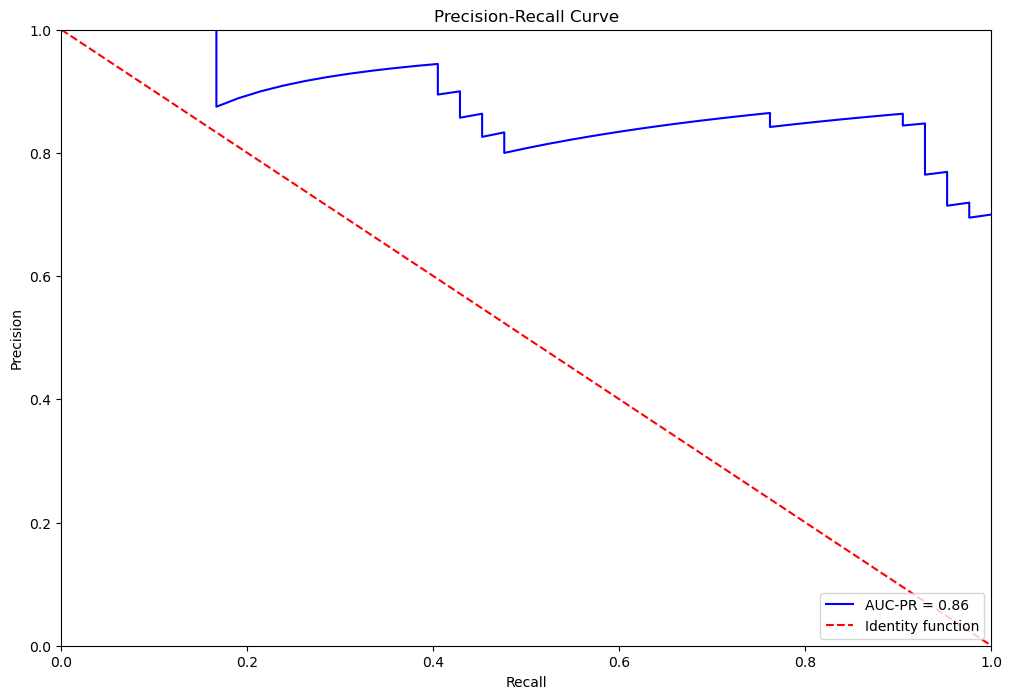

In [39]:
y_log = predict_log(X_test, d['beta'])
auc, precision, recall, th = precision_recall_curve(y_test_binary, y_log) 

plt.figure(figsize=(12,8))
plt.title(f'Precision-Recall Curve')
plt.plot(recall, precision, 'b', label=f'AUC-PR = {auc:0.2f}')
plt.plot([0, 1], [1,0], 'r--', label='Identity function')
plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

An AUC-PR of 0.86 suggests that the model has achieved a very good balance between precision and recall, meaning it is able to distinguish between the two classes very well. This implies that the model can both identify a large portion of positive instances (recall) and also that false positives are rare (precision). 

Therefore, this suggests that the model has a a high generalising power and can effectively predict unseen data, even when the dataset is imbalanced.

<a name="task-222"></a>

### (2.2.2) [(index)](#index-task-222)

In [40]:
def kernel_mat(X, Y, alpha):
    """
    Compute the kernel matrix using the Laplacian kernel.
    Parameters:
    - X (numpy.ndarray): Input matrix of shape (x, _).
    - Y (numpy.ndarray): Input matrix of shape (y, _).
    - alpha (float): Parameter controlling the shape of the kernel.
    Returns:
    - kernel (numpy.ndarray): Kernel matrix of shape (x, y).
    """
    # get number of rows in each input matrix
    x, _ = X.shape
    y, _ = Y.shape
    
    # initialise kernel matrix
    kernel = np.zeros((x, y))

    # compute kernel values using Laplacian kernel given in question
    for i in range(x):
        # compute L1 distance between current row of X and all rows of Y
        distances = np.linalg.norm(Y - X[i], ord=1, axis=1)
        # compute kernel values
        kernel[i, :] = np.exp(-distances * alpha)

    return kernel

In [41]:
def kernelised_predict_log(A, beta, intercept):
    """
    Predict the probability of belonging to a class using logistic regression applied to a kernel matrix.
    """
    y_log = logistic((A @ np.array(beta)) + intercept)
    return y_log.squeeze()

We construct the loss function: 

$E(L) = -\frac{1}{N} \sum (y^{(i)} log(h_{\beta,\beta_{0}}(x^{(i)})) + (1-y^{(i)}) log(1-h_{\beta,\beta_{0}}(x^{(i)})) + \frac{\lambda}{2} \beta^T A \beta$

$h_{\beta,\beta_{0}}(x) := \frac{1}{1 + e^{-(A \beta + \beta_{0})}}$ 

where A is the kernel matrix computed using the Laplacian kernel.

In [42]:
def kernelised_propagate(A, y, beta, intercept, lambda1 = 0.0025):
    """
    Compute the mean sample loss and its gradient for logistic regression applied to a kernel matrix.
    """
    y_log = kernelised_predict_log(A, beta, intercept)

    # mean sample loss function
    mean_loss = - np.mean(y * np.log(y_log) + (1-y) * np.log(1 - y_log)) + lambda1/2 * np.dot(beta.T, A @ beta)

    # derivatives
    dbeta = np.mean(A.T * (y_log - y) , axis=1).reshape(-1, 1) + lambda1 * A @ beta
    dintercept = np.mean((y_log - y)) 

    mean_loss = np.squeeze(mean_loss)
    
    # store gradients in a dictionary
    grads = {'dbeta': dbeta, "dintercept" : dintercept}
    
    return grads, mean_loss

In [43]:
def kernelised_optimise(A, y, beta, num_iterations=1000, learning_rate=0.1, print_loss=False):
    """
    Optimise the kernelised version of logistic regression parameters using gradient descent.
    """
    mean_loss_history = []
    intercept = 0
    
    for i in range(num_iterations):

        # calculating loss and gradients
        grads, mean_loss = kernelised_propagate(A, y, beta, intercept)
        
        # retrieving derivatives from grads
        dbeta = grads['dbeta']
        dintercept = grads['dintercept']

        # updating procedure
        beta = beta - learning_rate * dbeta
        intercept = intercept - learning_rate * dintercept

        # record loss values
        if i % 100 == 0:
            mean_loss_history.append(mean_loss)

        # printing loss every 100 iterations
        if print_loss and i % 100 == 0:
            print ('Mean loss after iteration %i: %f' %(i, mean_loss))

    # saving parameters and gradients in dictionary
    params = {'beta': beta, "intercept": intercept}
    grads = {'dbeta': dbeta, "dintercept" : dintercept}

    return params, grads, mean_loss_history

We analyse the loss function component by component. The logistic loss component is the negative log-likelihood of the logistic regression model, which is convex.

The regularisation component, given by $\frac{\lambda}{2} \beta^T A \beta$, is a quadratic function of $\beta$, and since the kernel matrix is positive semi-definite, this component is convex.

Since both components of the loss function are convex, the overall loss function is convex since summing two convex functions is convex. Therefore, optimising our loss function is a convex optimisation problem.

<a name="task-223"></a>

### (2.2.3) [(index)](#index-task-223)

In [44]:
def kernelised_predict(X_test, beta, intercept):
    """
    Predict the class labels for a given test set using kernelised logistic regression.
    """
    N_test = X_test.shape[0]
    y_pred = np.zeros((N_test, 1))
    beta = beta.reshape(X_test.shape[1], 1)
    
    # Predicting the probabilities
    y_log = kernelised_predict_log(X_test, beta, intercept)
    
    y_pred = y_log.round().reshape(1, -1) 

    return y_pred

In [45]:
def kernelised_model(X_train, y_train, X_test, y_test, alpha, num_iterations=2000, learning_rate=0.1, print_loss=False):
    """
    Train and evaluate a kernelised logistic regression model using Laplacian kernel.
    """
    A_train = kernel_mat(X_train, X_train, alpha)
    A_test = kernel_mat(X_test, X_train, alpha)
    
    # initialising parameters with zeros
    beta = initialise(A_train.shape[1])

    # gradient descent
    parameters, grads, mean_loss_history = kernelised_optimise(A_train, y_train, beta, num_iterations, learning_rate, print_loss=print_loss)

    # retrieving parameter vector beta from dictionary 'parameters'
    beta = parameters['beta']
    intercept = parameters['intercept']

    # predicting test and training set examples
    y_pred_test = kernelised_predict(A_test, beta,intercept)
    y_pred_train = kernelised_predict(A_train, beta, intercept)

    # printing train/test accuracy
    print('Training accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print('Test accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    # saving all information
    d = {'mean_loss_history': mean_loss_history, 'y_pred_test': y_pred_test, 'y_pred_train': y_pred_train, 'beta': beta, 'intercept': intercept, 'learning_rate': learning_rate, 'num_iterations': num_iterations}
    
    return d

In [46]:
np.random.seed(25)

In [47]:
# running the model
d1 = kernelised_model(X_train, y_train_binary, X_test, y_test_binary, alpha=100, num_iterations=500, learning_rate=0.1, print_loss=True)
print("alpha = 100")

Mean loss after iteration 0: 0.693147
Mean loss after iteration 100: 0.613842
Mean loss after iteration 200: 0.598316
Mean loss after iteration 300: 0.584775
Mean loss after iteration 400: 0.572512
Training accuracy: 67.58620689655173 %
Test accuracy: 70.0 %
alpha = 100


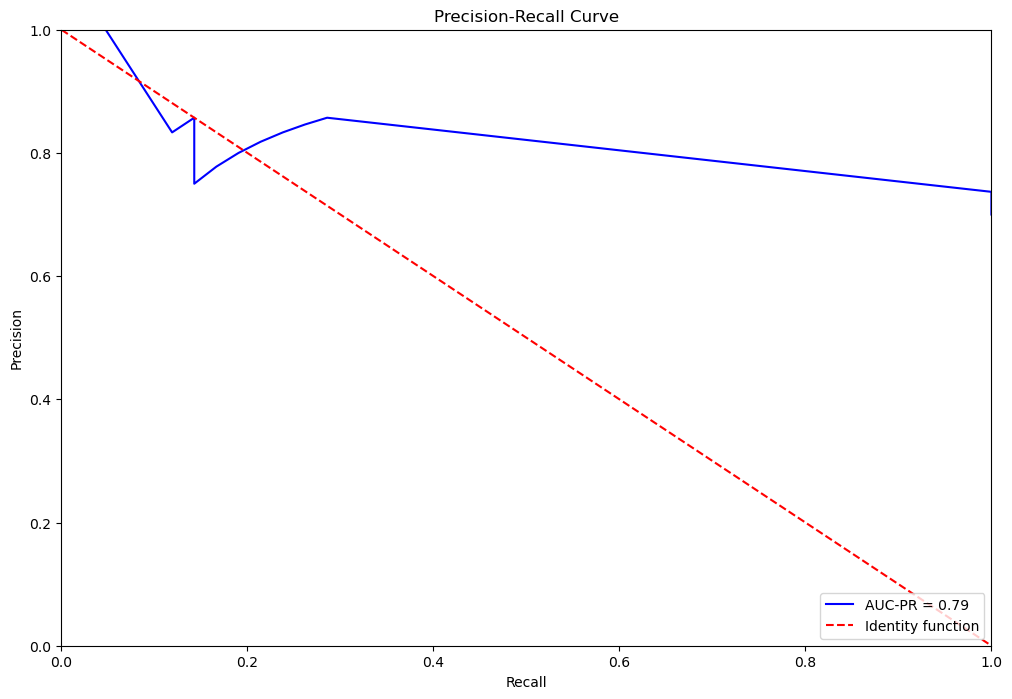

In [48]:
# plotting precision-recall curve
A_test1 = kernel_mat(X_test, X_train, 100)
y_log = kernelised_predict_log(A_test1, d1['beta'], d1['intercept'])
auc, precision, recall, th = precision_recall_curve(y_test_binary, y_log) 

plt.figure(figsize=(12,8))
plt.title(f'Precision-Recall Curve')
plt.plot(recall, precision, 'b', label=f'AUC-PR = {auc:0.2f}')
plt.plot([0, 1], [1,0], 'r--', label='Identity function')
plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [49]:
# running the model
d2 = kernelised_model(X_train, y_train_binary, X_test, y_test_binary, alpha=0.3, num_iterations=500, learning_rate=0.1, print_loss=True)
print("alpha = 0.3")

Mean loss after iteration 0: 0.693147
Mean loss after iteration 100: 0.528921
Mean loss after iteration 200: 0.497216
Mean loss after iteration 300: 0.480677
Mean loss after iteration 400: 0.469650
Training accuracy: 80.6896551724138 %
Test accuracy: 83.33333333333334 %
alpha = 0.3


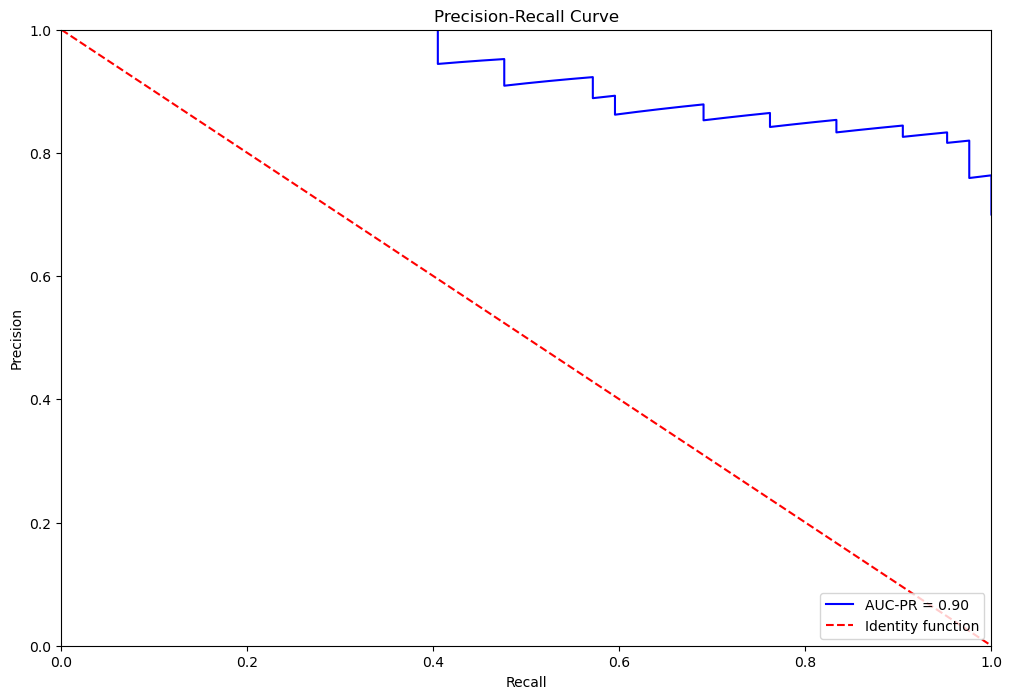

In [50]:
# plotting precision-recall curve
A_test2 = kernel_mat(X_test, X_train, 0.3)
y_log = kernelised_predict_log(A_test2, d2['beta'], d2['intercept'])
auc, precision, recall, th = precision_recall_curve(y_test_binary, y_log) 

plt.figure(figsize=(12,8))
plt.title(f'Precision-Recall Curve')
plt.plot(recall, precision, 'b', label=f'AUC-PR = {auc:0.2f}')
plt.plot([0, 1], [1,0], 'r--', label='Identity function')
plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

The precision-recall curves above imply that $\lambda = 0.3$ performs significantly better than $\lambda = 100$. We have an AUC-PR of 0.90 for $\lambda = 0.3$ and an AUC-PR of 0.79 for $\lambda = 100$, implying that the model with $\lambda = 0.3$ is far more effective at identifying positive instances and not predicting false positives.

The training and test accuracies also agree with this. For test set, the accuracy of the model with $\lambda = 100$ is 70.0% compared to 83.3% for the model with $\lambda = 0.3$.

Compared to the penalised logistic regression model in 2.1.1., the test accuracies are much higher, with only 56.7% for the model in 2.1.1. 

The logistic regression model does however have an AUC-PR of 0.86 which is second best overall, just behind the model with $\lambda = 0.3$.